# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import nibabel as nib
import os, shutil
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)


It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [3]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load all images and segmentation mask paths into lists called images_paths and labels_paths
path_main = '/data/TrainingSet'
images_path_main = os.path.join(path_main, 'images')
labels_path_main = os.path.join(path_main, 'labels')
images_paths = [f for f in sorted(os.listdir(images_path_main)) if 'nii' in f]
labels_paths = [f for f in sorted(os.listdir(labels_path_main)) if 'nii' in f]
print("The 3 first paths in:")
print(f'"images" folder: \n{images_paths[:3]}')
print(f'"labels" folder: \n{labels_paths[:3]} \n')
print(f'There are total: \n{len(images_paths)} images in "images" folder \n{len(labels_paths)} images in "labels" folder')

The 3 first paths in:
"images" folder: 
['hippocampus_001.nii.gz', 'hippocampus_003.nii.gz', 'hippocampus_004.nii.gz']
"labels" folder: 
['hippocampus_001.nii.gz', 'hippocampus_003.nii.gz', 'hippocampus_004.nii.gz'] 

There are total: 
263 images in "images" folder 
262 images in "labels" folder


In [4]:
# there is a different number of the images in the images and labels folders
# the names are matching in these folders, so they belong to the same study

# let's review and remove any files from the list which don't have a corresponding label or vs
outlier_images_paths = []
outlier_labels_paths = []
for images_path_tmp in images_paths:
    if images_path_tmp not in labels_paths:
        outlier_images_paths.append(images_path_tmp)
        images_paths.remove(images_path_tmp)
for labels_path_tmp in labels_paths:
    if labels_path_tmp not in images_paths:
        outlier_labels_paths.append(labels_path_tmp)
        labels_paths.remove(labels_path_tmp)
print("Outliers paths due to file naming in:")
print(f'"images" folder: \n{outlier_images_paths}')
print(f'"labels" folder: \n{outlier_labels_paths} \n')
print(f'There are total: \n{len(images_paths)} images in "image" folder \n{len(labels_paths)} images in "labels" folder')

Outliers paths due to file naming in:
"images" folder: 
['hippocampus_118.nii.gz']
"labels" folder: 
[] 

There are total: 
262 images in "image" folder 
262 images in "labels" folder


In [5]:
# Load an image and a segmentation mask into variables called image and label

# let's load the first image and it's corresponding label and check the np array size
image = nib.load(os.path.join(images_path_main, images_paths[0])).get_fdata()
label = nib.load(os.path.join(labels_path_main, labels_paths[0])).get_fdata()


In [6]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?


In [7]:
#What are the dimensions of the input arrays?
print('The dimensions of the input arrays:')
print(f'Image "{images_paths[0].split(os.sep)[-1]}" has size: {image.shape}')
print(f'Label "{labels_paths[0].split(os.sep)[-1]}" has size: {label.shape}')

The dimensions of the input arrays:
Image "hippocampus_001.nii.gz" has size: (35, 51, 35)
Label "hippocampus_001.nii.gz" has size: (35, 51, 35)


In [8]:
# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels. 
# You can adjust plot sizes like so if you find them too small:
# plt.rcParams["figure.figsize"] = (10,10)

# Use matplotlib, visualize a few slices from the dataset, along with their labels. 

# Let's write a function to show all 3 views of the image and it's corresponding label
def show_n_slices(images_arr, labels_arr, slices=None, aspect_ratio = [1, 1, 1]):
    '''
    This function visualize N slices along with their labesl
    images_arr: numpy array of the image
    labels_arr: numpy array of the label
    slices: list of the slices of interest (integers) [axial, coronal, sagittal] to visualize
    if None, would show the central slices
    aspect_ratio: list of aspect ratios for axial, coronal, sagittal ([1,1,1] is default)
    '''
    images_arr = np.flip(images_arr.T)
    labels_arr = np.flip(labels_arr.T)
    
    ax_slices = images_arr.shape[0]
    cor_slices = images_arr.shape[1]
    sag_slices = images_arr.shape[2]

    fig, ax = plt.subplots(2, 3, figsize=[10,6], constrained_layout=True)
    
    if slices is None:
        slice_ax_n = int(images_arr.shape[0] / 2)
        slice_cor_n = int(images_arr.shape[1] / 2)
        slice_sag_n = int(images_arr.shape[2] / 2)
    elif (slices[0] <= images_arr.shape[0]) & (slices[1] <= images_arr.shape[1]) & (slices[2] <= images_arr.shape[2]):
        slice_ax_n = int(slices[0])
        slice_cor_n = int(slices[1])
        slice_sag_n = int(slices[2])     
    else:
        return print('Wrong slices set')
    
    ax[0, 0].set_title(f'Axial slice {slice_ax_n}')
    ax[0, 0].imshow(images_arr[slice_ax_n, :, :], cmap='gray', \
                                  aspect = aspect_ratio[0], )
    ax[1, 0].set_title(f'Label for axial slice {slice_ax_n}')
    ax[1, 0].imshow(labels_arr[slice_ax_n, :, :], cmap='gray', \
                                  aspect = aspect_ratio[0])
    
    ax[0, 1].set_title(f'Coronal slice {slice_cor_n}')
    ax[0, 1].imshow(images_arr[:, slice_cor_n, :], cmap='gray', \
                                  aspect = aspect_ratio[1])
    ax[1, 1].set_title(f'Label for coronal slice {slice_cor_n}')
    ax[1, 1].imshow(labels_arr[:, slice_cor_n, :], cmap='gray', \
                                  aspect = aspect_ratio[1])
    
    ax[0, 2].set_title(f'Sagittal slice {slice_sag_n}')
    ax[0, 2].imshow(images_arr[:, :, slice_sag_n], cmap='gray', \
                                  aspect = aspect_ratio[2])
    ax[1, 2].set_title(f'Label for sagittal slice {slice_sag_n}')
    ax[1, 2].imshow(labels_arr[:, :, slice_sag_n], cmap='gray', \
                                  aspect = aspect_ratio[2])    
    plt.show()

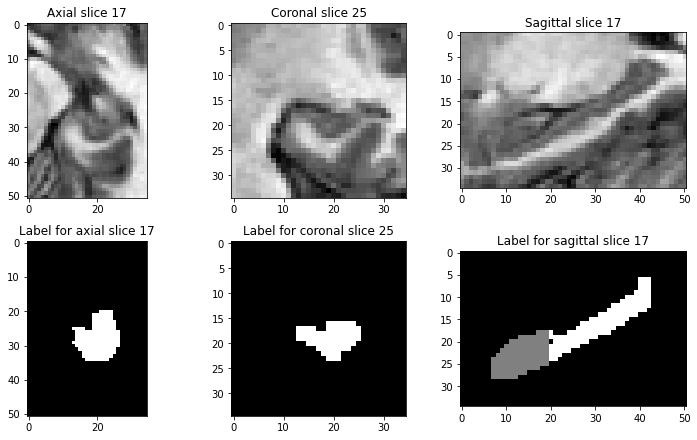

In [9]:
# show the center slice for all orientations [17,25,17]
show_n_slices(image, label)


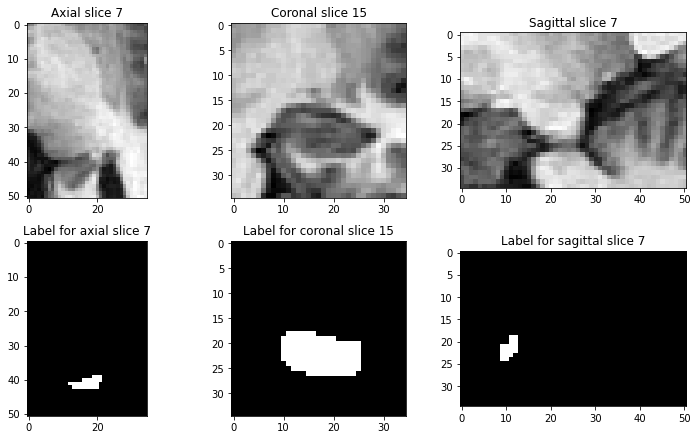

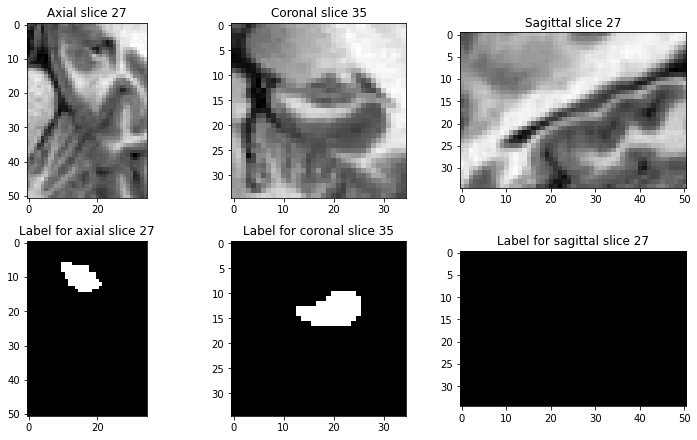

In [10]:
# show a couple off-center slices
show_n_slices(image, label, slices=[7,15,7])
show_n_slices(image, label, slices=[27,35,27])

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

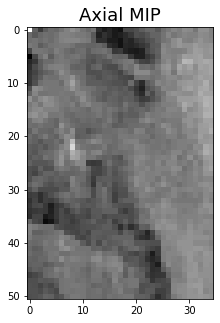

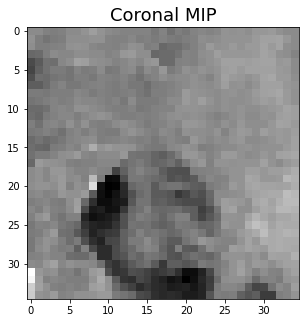

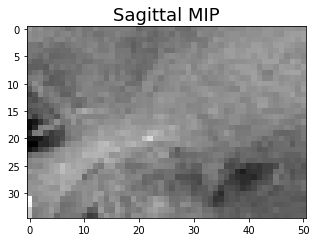

In [11]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes

# Lets visualize the Maximum Intensity Projections for all 3 orientations

# Axial
img_np = np.flip(image.T)
mip = np.zeros((img_np.shape[1], img_np.shape[2]))
for z in range(img_np.shape[0]):
    mip = np.maximum(mip, img_np[z, :, :])
plt.figure(figsize=(5,5))
plt.imshow(mip, cmap="gray")
plt.title('Axial MIP', fontsize=18)
plt.show()

# Coronal
mip = np.zeros((img_np.shape[0], img_np.shape[2]))
for z in range(img_np.shape[1]):
    mip = np.maximum(mip, img_np[:, z, :])
plt.figure(figsize=(5,5))
plt.imshow(mip, cmap="gray")
plt.title('Coronal MIP', fontsize=18)
plt.show()

# Sagittal
mip = np.zeros((img_np.shape[0], img_np.shape[1]))
for z in range(img_np.shape[2]):
    mip = np.maximum(mip, img_np[:, :, z])
plt.figure(figsize=(5,5))
plt.imshow(mip, cmap="gray")
plt.title('Sagittal MIP', fontsize=18)
plt.show()

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [12]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?
image_img = nib.load(os.path.join(images_path_main, images_paths[0]))
print(f'Image format is {str(image_img.header_class).split(".")[-2].upper()}')

Image format is NIFTI1


Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [13]:
# TASK: How many bits per pixel are used?
print(f'It is {image_img.header["bitpix"]} bits per pixel')

It is 8 bits per pixel


In [14]:
# TASK: What are the units of measurement?
# dictionary for units
xyzt_units_dic = {0: 'Unknown', 1: 'Meter (m)', 2: 'Milimeter (mm)', 3: 'Micron (µm)'}
# need to convert to binary, extract first 2 bits, and then conver to decimals (base 2)
coded_unit = int(bin(image_img.header["xyzt_units"])[:4], 2)
print(f'Units of measurement are {xyzt_units_dic[coded_unit]}')

Units of measurement are Milimeter (mm)


In [15]:
hdr = image_img.header
hdr.get_xyzt_units()

('mm', 'sec')

In [16]:
# TASK: Do we have a regular grid? What are grid spacings?
# Both spatial and temporal measurement units, used for the dimensions 
# dim[1] to dim[4] (x,y,z,t)
# pixdim[5] to dim[7] (x,y,z spacings)
grid_all = image_img.header['pixdim']
print(f'Grid Spacing: {grid_all}')

Grid Spacing: [1. 1. 1. 1. 1. 0. 0. 0.]


In [17]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?
# by convention, the nifti format, to be RAS: 
# R: x-axis is Right-to-Left: dim[1], sagittal
# A: y-axis is Anterior-to-Posterior: dim[2], coronal
# I: z-axis is Inferior-to-Superior: dim[3], axial
dim_all = image_img.header['dim']
print(f'Dimensions: {dim_all}\n')

print('The image orientation is RIS - Sagittal-Coronal-Axial') 
print(f'Matrix is {dim_all[1]}x{dim_all[2]}x{dim_all[3]}')
print(f'Voxels dimention is {grid_all[1]}x{grid_all[2]}x{grid_all[3]} mm\u00b3 with {grid_all[5:8]} spacing')

Dimensions: [ 3 35 51 35  1  1  1  1]

The image orientation is RIS - Sagittal-Coronal-Axial
Matrix is 35x51x35
Voxels dimention is 1.0x1.0x1.0 mm³ with [0. 0. 0.] spacing


In [18]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500
print(f'Hippocamus volume of the {labels_paths[0].split(os.sep)[-1][:-7]} image is {(label > 0).sum()} mm\u00b3')

Hippocamus volume of the hippocampus_001 image is 2948 mm³


## Plotting some charts

In [19]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.

<img src="img/nomogram_fem_right.svg" width=400 align=left>

Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [20]:
def get_label_volume(img_img_path, lbl_img_path):
    '''
    input: is a path to NIFTI image and corrsponding label
    output: image matrix (array), image voxel dimentions (array), 
            label matrix (array), label voxel dimentions (array), labeled volume (float)
    '''
    lbl_img = nib.load(lbl_img_path)
    lbl_arr = lbl_img.get_fdata()
    vox_vol = lbl_img.header['pixdim'][1:4].prod()
    
    img_img = nib.load(img_img_path)
    
    return img_img.header['dim'][1:4], img_img.header['pixdim'][1:4], lbl_img.header['dim'][1:4], lbl_img.header['pixdim'][1:4], vox_vol*(lbl_arr > 0).sum()

#get_label_volume(os.path.join(lbl_path_main, lbl_paths[10]))

# compute all volumes
volumes_all_dic = {path_tmp: get_label_volume(os.path.join(images_path_main, path_tmp), \
                                                 os.path.join(labels_path_main, path_tmp)) \
               for path_tmp in labels_paths}

print(f'There are total {len(volumes_all_dic.keys())} volumes')

There are total 262 volumes


In [21]:
import pandas as pd

In [22]:
df_all = pd.DataFrame.from_dict(volumes_all_dic, orient='index').reset_index()
df_all.columns=['image_name', 'img_matrix', 'img_voxel_size', 'lbl_matrix', \
                'lbl_voxel_size', 'lbl_volume']
display(df_all.head(20))
# check volume stats for outliers
print('Volume statistics')
display(df_all['lbl_volume'].describe())

,image_name,img_matrix,img_voxel_size,lbl_matrix,lbl_voxel_size,lbl_volume
0,hippocampus_001.nii.gz,"[35, 51, 35]","[1.0, 1.0, 1.0]","[35, 51, 35]","[1.0, 1.0, 1.0]",2948.0
1,hippocampus_003.nii.gz,"[34, 52, 35]","[1.0, 1.0, 1.0]","[34, 52, 35]","[1.0, 1.0, 1.0]",3353.0
2,hippocampus_004.nii.gz,"[36, 52, 38]","[1.0, 1.0, 1.0]","[36, 52, 38]","[1.0, 1.0, 1.0]",3698.0
3,hippocampus_006.nii.gz,"[35, 52, 34]","[1.0, 1.0, 1.0]","[35, 52, 34]","[1.0, 1.0, 1.0]",4263.0
4,hippocampus_007.nii.gz,"[34, 47, 40]","[1.0, 1.0, 1.0]","[34, 47, 40]","[1.0, 1.0, 1.0]",3372.0
5,hippocampus_008.nii.gz,"[36, 48, 40]","[1.0, 1.0, 1.0]","[36, 48, 40]","[1.0, 1.0, 1.0]",3248.0
6,hippocampus_010.nii.gz,"[512, 512, 241]","[0.597656, 0.597656, 1.25]","[36, 50, 31]","[1.0, 1.0, 1.0]",3456.0
7,hippocampus_011.nii.gz,"[36, 50, 31]","[1.0, 1.0, 1.0]","[36, 50, 31]","[1.0, 1.0, 1.0]",3456.0
8,hippocampus_014.nii.gz,"[39, 50, 40]","[1.0, 1.0, 1.0]","[39, 50, 40]","[1.0, 1.0, 1.0]",3622.0
9,hippocampus_015.nii.gz,"[42, 51, 28]","[1.0, 1.0, 1.0]","[42, 51, 28]","[1.0, 1.0, 1.0]",2819.0


Volume statistics


count      262.000000
mean      3496.311566
std       3273.781003
min       2382.000000
25%       2951.500000
50%       3330.000000
75%       3626.750000
max      55823.630371
Name: lbl_volume, dtype: float64

Let's find what is wrong with the images with the hippocampal volume below 2200mm3 and above 4500mm3, and if there is any images with voxels different from 1 mm3 or matrix and voxel size are different for image and label

In [23]:
suspicious_volumes = df_all[(df_all['lbl_volume'] < 2200) | \
                            (df_all['lbl_volume'] > 4500) | \
                            (df_all['lbl_voxel_size'].apply(lambda x: x.prod()) != 1.) | \
                            (df_all['img_voxel_size'].apply(lambda x: x.prod()) != 1.) | \
                            ((df_all['img_matrix'].apply(lambda x: x.prod()) != \
                            df_all['lbl_matrix'].apply(lambda x: x.prod()))) ]
suspicious_volumes

,image_name,img_matrix,img_voxel_size,lbl_matrix,lbl_voxel_size,lbl_volume
6,hippocampus_010.nii.gz,"[512, 512, 241]","[0.597656, 0.597656, 1.25]","[36, 50, 31]","[1.0, 1.0, 1.0]",3456.000000
179,hippocampus_281.nii.gz,"[512, 512, 31]","[0.785156, 0.785156, 7.5]","[512, 512, 94]","[0.734375, 0.734375, 5.0]",55823.630371


In [24]:
# remove outliers form the dataframe
df_all_final = df_all.copy()
for name_tmp in suspicious_volumes['image_name']:
    df_all_final.drop(df_all_final[df_all_final['image_name'] == name_tmp].index, inplace=True)
# print outliers
outlier_final_arr = np.array(outlier_images_paths + list(suspicious_volumes.image_name))
print(f'Outliers: \n{outlier_final_arr}')
print(f'Total images before outliers removal {df_all.shape[0]}')
print(f'Total images after outliers removal {df_all_final.shape[0]}')

Outliers: 
['hippocampus_118.nii.gz' 'hippocampus_010.nii.gz'
 'hippocampus_281.nii.gz']
Total images before outliers removal 262
Total images after outliers removal 260


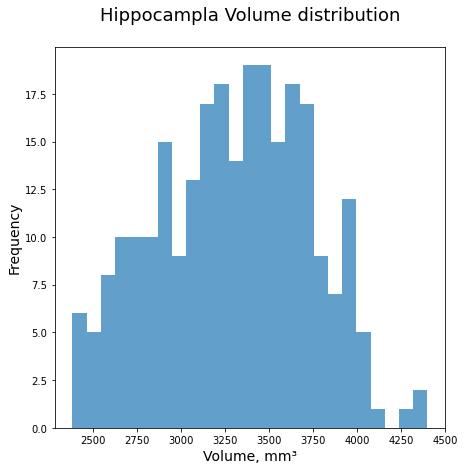

In [25]:
# plot histogram
plt.figure(figsize=(7,7))
df_all_final['lbl_volume'].plot.hist(bins=25, alpha=0.7)
plt.title(f'Hippocampla Volume distribution\n', fontsize=18)
plt.xlabel(f'Volume, mm\u00b3', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [26]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section
cwd = os.getcwd()
img_out = os.path.join(cwd, '/images/')
lbl_out = os.path.join(cwd, '/labels/')

if os.path.isdir(img_out) == False:
    os.mkdir(img_out)
if os.path.isdir(lbl_out) == False:
    os.mkdir(lbl_out)

for name_tmp in df_all_final['image_name']:
    shutil.copy(os.path.join(images_path_main, name_tmp), img_out)
    shutil.copy(os.path.join(labels_path_main, name_tmp), lbl_out)


In [27]:
# check how many images in each out folder
print(f'There are {len(os.listdir(img_out))} images in: {img_out[-22:]}')
print(f'There are {len(os.listdir(lbl_out))} images in: {lbl_out[-22:]}')

There are 260 images in: /images/
There are 260 images in: /labels/


The ‘dirty’ dataset consists of:
263 files in "image" folder
262 files in "labels" folder

We have identified and removed these 3 susticious files:

* 'hippocampus_118.nii.gz' – it does not have a label
* ‘hippocampus_010.nii.gz’ and ‘hippocampus_281.nii.gz’  – these two files have a different image matrix size and image volume size.

So after removing these 3 suspicious files, we have 260 files in “image” folder and 260 files in “labels” folder


## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!